In [23]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import pickle

In [24]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [25]:

# ==========================================================
# Configuration
# ==========================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 128
NUM_WORKERS = 4

g = torch.Generator()
g.manual_seed(42)

# ==========================================================
# Transforms
# ==========================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# ==========================================================
# Datasets and Splits
# ==========================================================
# Load once (without transform)
full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
full_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)

# Split indices using a fixed seed generator
train_indices, val_indices = random_split(range(len(full_train)), [45000, 5000], generator=g)
test_indices, small_test_indices = random_split(range(len(full_test)), [7500, 2500], generator=g)

# Wrap each subset with its own dataset and transform
train_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=True, transform=train_transform),
    train_indices.indices
)
val_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=True, transform=test_transform),
    val_indices.indices
)
test_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=False, transform=test_transform),
    test_indices.indices
)
small_test_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=False, transform=test_transform),
    small_test_indices.indices
)

print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))
print("Small test size:", len(small_test_dataset))

# ==========================================================
# Dataloaders
# ==========================================================
def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_dataset, shuffle=True)
val_loader = get_loader(val_dataset, shuffle=False)
test_loader = get_loader(test_dataset, shuffle=False)
small_test_loader = get_loader(small_test_dataset, shuffle=False)


Training set size: 45000
Validation set size: 5000
Test set size: 7500
Small test size: 2500


In [26]:
def plot_weight_histograms(model, title):
    # Collect (layer_name, weights) pairs
    layer_weights = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            layer_weights.append((name, module.weight.detach().cpu().numpy().flatten()))

    # Plot histograms
    plt.figure(figsize=(15, 8))
    for i, (name, w) in enumerate(layer_weights[:11]):  # limit to first 11 for readability
        plt.subplot(5, 6, i + 1)
        plt.hist(w, bins=40, color='blue', alpha=0.7)
        plt.title(name, fontsize=9)  # <-- actual layer name
        plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

In [27]:
vgg11 = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11.classifier[6] = torch.nn.Linear(4096, 100)
vgg11.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
vgg11.load_state_dict(torch.load('models/vgg11_cifar100_baseline.pt', weights_only=True, map_location=device))
vgg11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [28]:
with open('models/sensitivity_dict_unstructured.pkl', 'rb') as f:
    sensitivity_dict = pickle.load(f)

In [29]:
def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [30]:
base_acc = evaluate(vgg11, test_loader, device)
print(f"Base Acc: {base_acc:.2f}%")

base_acc = evaluate(vgg11, small_test_loader, device)
print(f"Base Acc (small): {base_acc:.2f}%")

Base Acc: 74.33%
Base Acc (small): 73.28%


In [31]:
prune_amts = [10, 20, 30, 40, 50, 60, 70, 80, 90]
desired_prune = 0.7
max_layer_prune = 0.9
min_layer_prune = 0.1  # don't prune below 10% to avoid imbalance

# 1) gather layers and parameter counts
layer_param_count = {}
conv_order = []  # track order for depth weighting
for name, module in vgg11.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        nparams = sum(p.numel() for p in module.parameters())
        layer_param_count[name] = nparams
        conv_order.append(name)

total_params = sum(layer_param_count.values())
total_remove_target = int(desired_prune * total_params)

# 2) compute robustness R_l (lower R = more sensitive)
R = {}
for name in layer_param_count:
    accs = []
    for p in prune_amts:
        acc = sensitivity_dict.get((name, p))
        if acc is not None:
            accs.append(acc)
    if not accs or base_acc == 0:
        R[name] = 1.0
    else:
        R[name] = (sum(accs) / len(accs)) / base_acc

print("Robustness:")
print(R)

# 3) convert robustness to sensitivity (S = 1 / R) with clamping
S = {n: 1.0 / max(R[n], 1e-6) for n in R}

# 4) apply depth weighting (deeper layers get more pruning)
depth_weights = {}
for i, name in enumerate(conv_order):
    depth_weights[name] = 1.0 + (i / len(conv_order))  # linear increase by depth

# 5) combine into pruning importance score
# lower S -> less pruning; higher depth -> more pruning
score = {n: depth_weights[n] / S[n] for n in layer_param_count}

# 6) allocate pruning proportionally to score * param_count
denom = sum(score[n] * layer_param_count[n] for n in score)
remove_alloc = {}
for name in score:
    remove_alloc[name] = total_remove_target * (score[name] * layer_param_count[name]) / denom

# 7) compute final per-layer pruning %
prune_pct = {}
for name in remove_alloc:
    pct = remove_alloc[name] / layer_param_count[name]
    pct = min(max(pct, min_layer_prune), max_layer_prune)
    prune_pct[name] = pct

print("\nAdjusted Prune Percentages:")
for k, v in prune_pct.items():
    print(f"{k}: {v*100:.2f}%")

Robustness:
{'features.0': 0.8381246967491509, 'features.3': 0.9910237748665696, 'features.6': 0.9933891314895681, 'features.8': 0.984049005337215, 'features.11': 0.983927704997574, 'features.13': 0.9818049490538572, 'features.16': 0.9685225618631731, 'features.18': 0.9704633672974283, 'classifier.0': 0.9955725376031054, 'classifier.3': 0.9961183891314895, 'classifier.6': 0.9970887918486171}

Adjusted Prune Percentages:
features.0: 34.25%
features.3: 44.18%
features.6: 47.97%
features.8: 51.18%
features.11: 54.83%
features.13: 58.35%
features.16: 61.16%
features.18: 64.89%
classifier.0: 70.27%
classifier.3: 74.01%
classifier.6: 77.78%


In [32]:
def prune_layer_unstructured_L2(module, amount=0.3):
    # Only prune Conv2d or Linear layers
    if not isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        return 0

    with torch.no_grad():
        # Flatten weights
        weights = module.weight.data.view(-1)
        num_params = weights.numel()
        num_prune = int(amount * num_params)

        if num_prune == 0:
            return 0

        # Compute L2 magnitudes (since weights are scalars, this is just abs)
        magnitudes = weights.abs()

        # Get threshold
        threshold = torch.topk(magnitudes, num_prune, largest=False).values.max()

        # Zero out the smallest weights
        mask = magnitudes > threshold
        module.weight.data.view(-1)[~mask] = 0

        return num_prune

In [33]:
# 5) apply pruning (use a copy of the model)
vgg_pruned = copy.deepcopy(vgg11)

for name, module in vgg_pruned.named_modules():
    if name in prune_pct:
        p = prune_pct[name]
        if p <= 0:
            continue
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            try:
                prune_layer_unstructured_L2(module, amount=p)
            except Exception as e:
                print(f"Cannot prune layer {name}: {e}")


In [34]:
def count_nonzero_params(model):
    total, nonzero = 0, 0
    for p in model.parameters():
        total += p.numel()
        nonzero += p.nonzero().size(0)
    print(f"Sparsity: {(1 - nonzero / total) * 100:.2f}% ({nonzero}/{total} nonzero)")
    return nonzero, total

count_nonzero_params(vgg_pruned)

Sparsity: 69.99% (38760361/129176036 nonzero)


(38760361, 129176036)

In [35]:
# Print per-layer pruning summary
print(f"{'Layer':<35} {'Type':<15} {'Total Params':>15} {'Pruned %':>10} {'Pruned Params':>15}")
print("=" * 95)

total_params_before = sum(layer_param_count.values())
total_pruned_params = 0

for name, module in vgg_pruned.named_modules():
    if name in prune_pct and isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        total = layer_param_count[name]
        pct = prune_pct[name]
        pruned = int(total * pct)
        total_pruned_params += pruned
        print(f"{name:<35} {type(module).__name__:<15} {total:>15,} {pct*100:>9.1f}% {pruned:>15,}")

print("=" * 95)
print(f"{'Total model parameters before pruning:':<60} {total_params_before:,}")
print(f"{'Total parameters pruned:':<60} {total_pruned_params:,}")
print(f"{'Remaining parameters after pruning:':<60} {total_params_before - total_pruned_params:,}")
print(f"{'Overall prune percentage:':<60} {(total_pruned_params / total_params_before) * 100:.2f}%")


Layer                               Type               Total Params   Pruned %   Pruned Params
features.0                          Conv2d                    1,792      34.2%             613
features.3                          Conv2d                   73,856      44.2%          32,627
features.6                          Conv2d                  295,168      48.0%         141,598
features.8                          Conv2d                  590,080      51.2%         301,982
features.11                         Conv2d                1,180,160      54.8%         647,026
features.13                         Conv2d                2,359,808      58.4%       1,377,046
features.16                         Conv2d                2,359,808      61.2%       1,443,317
features.18                         Conv2d                2,359,808      64.9%       1,531,281
classifier.0                        Linear              102,764,544      70.3%      72,209,859
classifier.3                        Linear        

In [36]:
torch.save(vgg_pruned.state_dict(), "vgg11_cifar100_pruned_unstructured.pt")

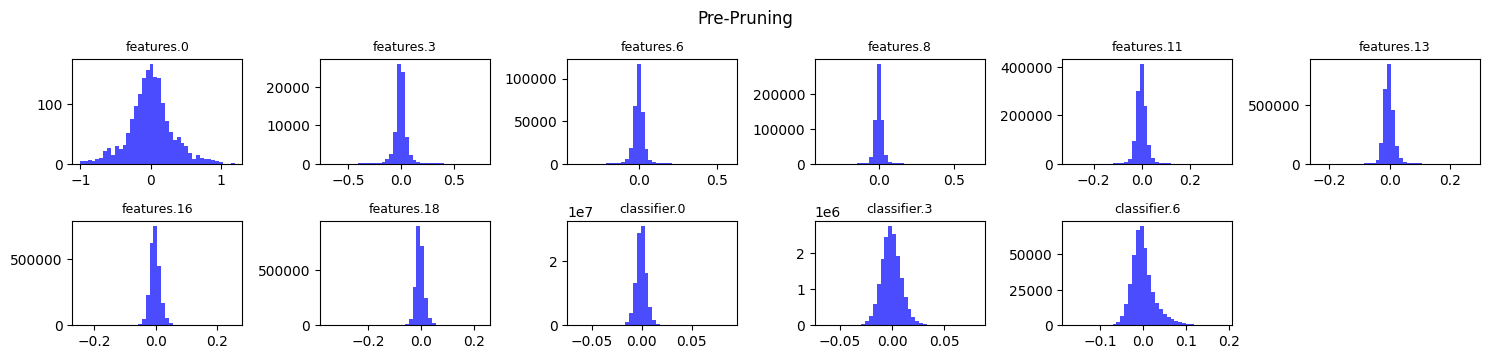

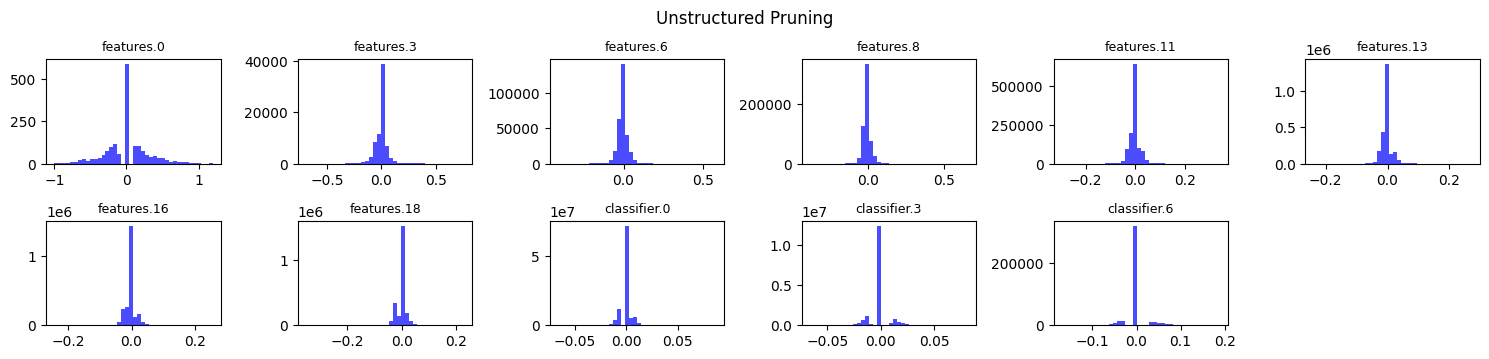

In [37]:
plot_weight_histograms(vgg11, "Pre-Pruning")
plot_weight_histograms(vgg_pruned, "Unstructured Pruning")

In [38]:

acc = evaluate(vgg_pruned, test_loader, device)
print(f"Post-Pruning no finetuning accuracy: {acc:.2f}%")

acc = evaluate(vgg_pruned, small_test_loader, device)
print(f"Post-Pruning no finetuning accuracy (small): {acc:.2f}%")

Post-Pruning no finetuning accuracy: 72.73%
Post-Pruning no finetuning accuracy (small): 71.44%
